# Módulo de Processamento de Imagens

## Código

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
def imread(path):
    img = Image.open(path).convert('RGB')
    return np.array(img)


def imshow(img, cmap=None, vmin=0, vmax=255):
    plt.axis('off')
    plt.imshow(img, cmap, vmin=vmin, vmax=vmax)


def imwrite(img, name):
    Image.fromarray(img).save(name)


def rgb_to_yiq(img, round=2):
    yiq = np.array([
        [0.299, 0.596, 0.211],
        [0.587, -0.274, -0.523],
        [0.114, -0.322, 0.312]
    ])
    shape = img.shape
    img_output = img.copy().reshape(-1, 3).astype(float)
    return np.dot(img_output, yiq).round(round).reshape(shape)


def yiq_to_rgb(img, round=2):
    inv_yiq = np.array([
        [1, 1, 1],
        [0.956, -0.272, -1.106],
        [0.621, -0.647, 1.703]
    ])
    shape = img.shape
    img = img.copy().reshape(-1, 3).astype(float)
    rgb = np.dot(img, inv_yiq).round(round).reshape(shape)
    return np.clip(rgb, 0, 255).astype('uint8')


def negative(img):
    return 255 - img


def padding(img, fsize, pivot):
    zeros = np.zeros((
        img.shape[0]+fsize[0]-1, 
        img.shape[1]+fsize[1]-1
    )).astype(float)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            zeros[pivot[0] + i, pivot[1] + j] = img[i, j]
    return zeros


def correlate(img, filter, pivot, offset=0):
    img_output = img.copy().astype(float)
    for k in range(img.shape[2]):
        img_padded = padding(img[:, :, k], filter.shape, pivot)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                view = img_padded[i:i+filter.shape[0], j:j+filter.shape[1]]
                pixel = np.sum(np.multiply(filter, view))
                img_output[i, j, k] = pixel + offset
    return img_output


def median_blur(img, fsize, pivot):
    is_even = lambda value: value % 2 == 0
    if is_even(fsize[0]) or is_even(fsize[1]):
        raise Exception('As dimensões do filtro não são ímpares')

    img_output = img.copy()
    for k in range(img.shape[2]):
        img_padded = padding(img[:, :, k], filter.shape, pivot)
        img_padded = img_padded.astype('uint8')
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                view = img_padded[i:i+filter.shape[0], j:j+filter.shape[1]]
                pixel = np.median(view)
                img_output[i, j, k] = pixel
    return img_output


def rgb2hsv(r, g, b):
    cmax = max(r, g, b) 
    cmin = min(r, g, b)    
    delta = cmax - cmin  
    value = cmax 

    saturation = 0.0 if value == 0 else delta / cmax

    if saturation == 0:
        hue = 0.0
    else:
        if r == cmax:
            hue = (g - b) / delta
        elif g == cmax:
            hue = 2 + (b - r) / delta
        elif b == cmax:
            hue = 4 + (r - g) / delta
        hue = hue * 60
        hue = hue + 360 if hue < 0 else hue

    hue = np.round(hue, 2)
    saturation = np.round(saturation, 2)
    value = np.round(value / 255, 2)

    return hue, saturation, value 

def rgb_to_hsv(img):
    img = img.copy().astype(float)
    img_output = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_output[i, j] = rgb2hsv(*img[i, j])
    return img_output


def hsv2rgb(h, s, v):
    if s == 0:
        r = v; g = v; b = v
    else:
        h = 0 if h == 360 else h / 60
        i = int(h)
        f = h - i

        p = v * (1.0 - s)
        q = v * (1.0 - s * f)
        t = v * (1.0 - s * (1.0 - f ))

        if i == 0:
            r = v; g = t; b = p
        elif i == 1:
            r = q; g = v; b = p
        elif i == 2:
            r = p; g = v; b = t
        elif i == 3:
            r = p; g = q; b = v
        elif i == 4:
            r = t; g = p; b = v
        else:
            r = v; g = p; b = q
    return round(255*r), round(255*g), round(255*b)


def hsv_to_rgb(img):
    img_output = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img_output[i, j] = hsv2rgb(*img[i, j])
    return img_output.astype('uint8')


def saturation_control(img, saturation):
    hsv_img = rgb_to_hsv(img)
    hsv_img[:, :, 1] = saturation
    return hsv_to_rgb(hsv_img)


def hist(img):
    counter = np.zeros(256).astype('uint8')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            counter[img[i, j]] += 1 
    return counter


def hist_plot(img):
    plt.plot(hist(img))
    plt.show()
    

def hist_stretch(img):
    gray_img = img[:, :, 0].copy()
    output = gray_img.copy()
    grays = np.nonzero(hist(gray_img))[0]
    rmax = np.max(grays)
    rmin = np.min(grays) 

    stretched = np.round(((grays - rmin) / (rmax - rmin)) * 255)
    stretched = stretched.clip(0, 255).astype('uint8')

    mapping = dict(zip(grays, stretched))

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = gray_img[i, j]
            output[i, j] = mapping[pixel]
    return np.dstack((output, output, output))

## 1. RGB-YIQ-RGB

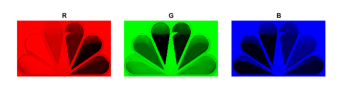

In [ ]:
img = imread('/content/colors_02.png')
imshow(img)

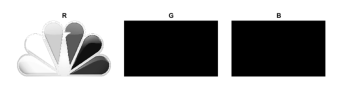

In [ ]:
imshow(img[:,:,0], cmap='gray')

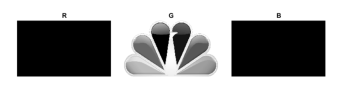

In [ ]:
imshow(img[:,:,1], cmap='gray')

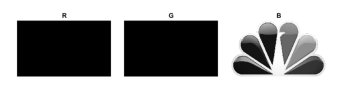

In [ ]:
imshow(img[:,:,2], cmap='gray')

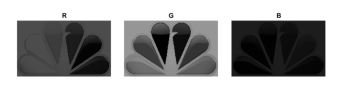

In [ ]:
img_yiq = rgb_to_yiq(img)
imshow(img_yiq[:, :, 0], cmap='gray')

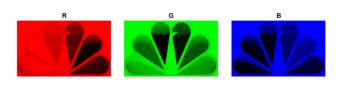

In [ ]:
imshow(yiq_to_rgb(img_yiq))

## 2. Negativo

### Exemplo RGB

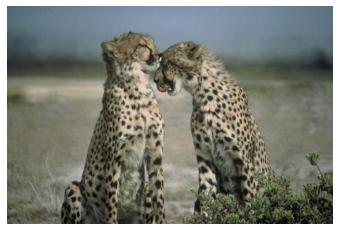

In [ ]:
img = imread('/content/leopardo.gif')
imshow(img)

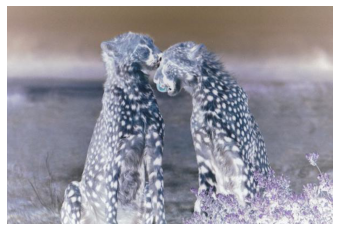

In [ ]:
imshow(negative(img))

### Exemplo YIQ

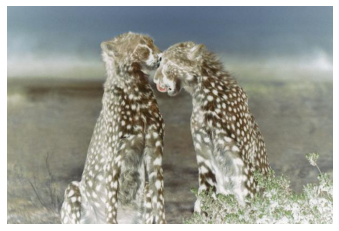

In [ ]:
img_yiq = rgb_to_yiq(img)
img_yiq[:, :, 0] = negative(img_yiq[:, :, 0])
imshow(yiq_to_rgb(img_yiq))

## 3. Correlação

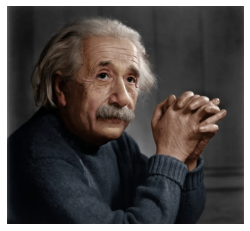

In [ ]:
img = imread('/content/albert-einstein-1536x1413.webp')
imshow(img)

### Offset

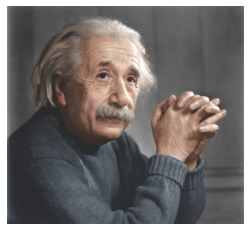

In [ ]:
identity = np.array([[1]])
result = correlate(img, identity, (0, 0), 40)
brighter_img = result.clip(0, 255).astype('uint8')
imshow(brighter_img)

### Filtro Média

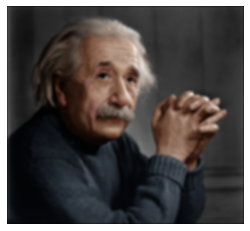

In [ ]:
mean = np.ones((15, 15)) * (1/225)
result = correlate(img, mean, (7, 7))
blurred_img = result.clip(0, 255).astype('uint8')
imshow(blurred_img)

### Sobel

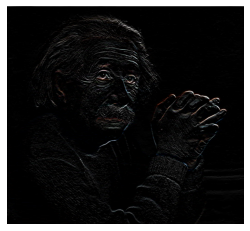

In [ ]:
sobelx = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])
sobely = sobelx.transpose()

result = correlate(img, sobelx, (1, 1))
img_sobelx = np.abs(result.clip(0, 255)).astype('uint8')
imshow(img_sobelx)

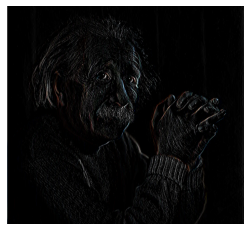

In [ ]:
result = correlate(img, sobely, (1, 1))
img_sobely = np.abs(result.clip(0, 255)).astype('uint8')
imshow(img_sobely)

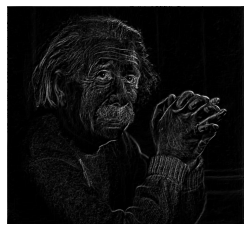

In [ ]:
sobelxy = img_sobelx + img_sobely
sobel = sobelxy.clip(0, 255).astype('uint8')
sobel_stretched = hist_stretch(sobel) 
imshow(sobel_stretched, cmap='gray')

### Histograma

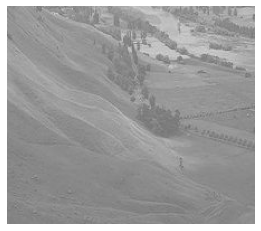

In [ ]:
img = imread('/content/Captura de tela 2022-10-23 023527.png')
imshow(img, cmap='gray')

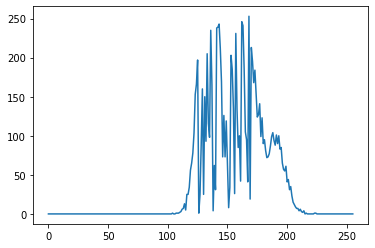

In [ ]:
hist_plot(img)

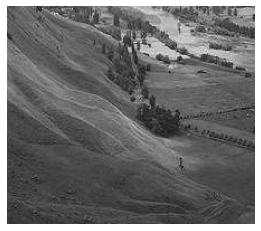

In [ ]:
img_stretched = hist_stretch(img) 
imshow(img_stretched, cmap='gray')

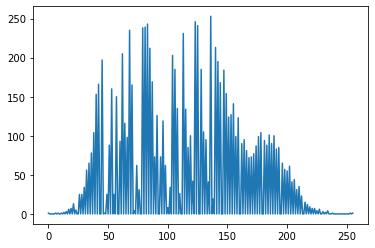

In [ ]:
hist_plot(img_stretched)

## 4. Filtro da Mediana

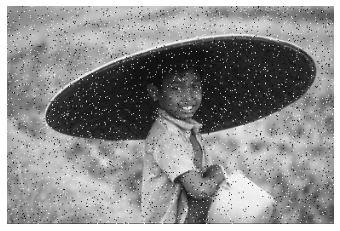

In [ ]:
img = imread('/content/menininho.png')
imshow(img)

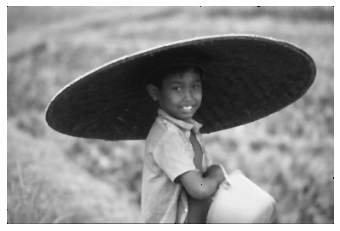

In [ ]:
median_img = median_blur(img, (3, 3), (1, 1))
imshow(median_img)

## 5. Controle de Saturação

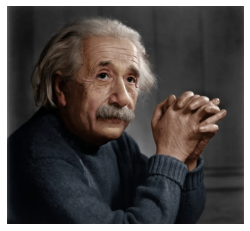

In [ ]:
img = imread('/content/albert-einstein-1536x1413.webp')
imshow(img)

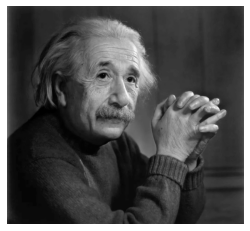

In [ ]:
imshow(saturation_control(img, 0))

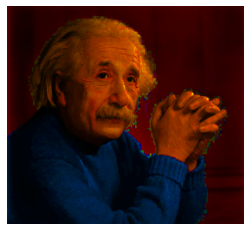

In [ ]:
imshow(saturation_control(img, 1))